In [43]:


import os
from IPython.display import Audio
import librosa
import librosa.display as disp
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed, Flatten, BatchNormalization, Conv1D  # Correct import for Conv1D
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2 

from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [4]:
def load_data(path):
    _emotions = []  # To store emotions
    f_paths = []    # To store file paths

    # List all folders in the directory
    folders = os.listdir(path)
    
    for folder in folders:
        folder_path = os.path.join(path, folder)  # Correctly join the folder with the base path
        
        # Check if it's actually a folder
        if os.path.isdir(folder_path):
            files = os.listdir(folder_path)
            
            # Loop through the files in each folder
            for file in files:
                step = file.split('.')[0]  # Get the filename without extension
                step = step.split('-')[2]  # Extract the emotion number from the filename
                
                _emotions.append(int(step))  # Append the emotion (convert to int)
                
                # Append the full file path
                f_paths.append(os.path.join(folder_path, file))

    return [_emotions, f_paths]  # Return both lists

# Function to map emotion number to emotion name
def get_emotion(number):
    info = {
        1: 'neutral',
        2: 'calm',
        3: 'happy',
        4: 'sad',
        5: 'angry',
        6: 'fearful',
        7: 'disgust',
        8: 'surprised'
    }
    return info.get(number, "Unknown emotion")

# Specify the path to the data folder
path = r'C:\Users\Computing\Downloads\speech-emotion-recognition-ravdess-data(7)'

# Call the load_data function to load emotions and file paths
emotions, paths = load_data(path)

# For demonstration, print the first 5 emotions and their corresponding file paths
for i in range(5):
    print(f"Emotion: {get_emotion(emotions[i])}, File Path: {paths[i]}")

Emotion: neutral, File Path: C:\Users\Computing\Downloads\speech-emotion-recognition-ravdess-data(7)\Actor_01\03-01-01-01-01-01-01.wav
Emotion: neutral, File Path: C:\Users\Computing\Downloads\speech-emotion-recognition-ravdess-data(7)\Actor_01\03-01-01-01-01-02-01.wav
Emotion: neutral, File Path: C:\Users\Computing\Downloads\speech-emotion-recognition-ravdess-data(7)\Actor_01\03-01-01-01-02-01-01.wav
Emotion: neutral, File Path: C:\Users\Computing\Downloads\speech-emotion-recognition-ravdess-data(7)\Actor_01\03-01-01-01-02-02-01.wav
Emotion: calm, File Path: C:\Users\Computing\Downloads\speech-emotion-recognition-ravdess-data(7)\Actor_01\03-01-02-01-01-01-01.wav


In [5]:
def read_audio(path):
    data, sample_rate = librosa.load(path, duration=2.4, offset=0.6)
    return data, sample_rate

# Function to draw the waveform
def draw_wave(path, data, sr):
    plt.figure(figsize=(10, 4))
    plt.title('Audio wave :: ' + path, fontsize=17)  # Use 'fontsize' instead of 'size'
    disp.waveshow(data, sr=sr)
    plt.show()

# Function to draw the spectrogram
def draw_spectrogram(path, data, sr):
    plt.figure(figsize=(10, 4))
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.title('Spectrogram for wave :: ' + path, fontsize=17)  # Use 'fontsize' instead of 'size'
    disp.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')  # Add color bar for better visualization
    plt.show()

# Noise addition
def add_noise(data, sr):
    noise = 0.035 * np.random.uniform() * np.amax(data)
    data += noise * np.random.normal(size=data.shape[0])
    return data, sr

# Shifting
def shift(data, sr):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    shifted = np.roll(data, shift_range)
    return shifted, sr

# Pitch shifting
def pitch(data, sr, factor=0.7):
    pitched = librosa.effects.pitch_shift(y=data, sr=sr, n_steps=factor)
    return pitched, sr

# Time stretching
def stretch(data, sr, rate=0.85):
    stretched = librosa.effects.time_stretch(y=data, rate=rate)
    return stretched, sr

# Feature extraction
def feature_extraction(data, sr):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return mfcc

# Audio processing
def processing_audio(data, sr, options):
    func = random.choice(options)
    
    if func == 'standard':
        # No processing, just return the original data
        processed = data
    else:
        # Apply the selected function
        processed, _ = func(data, sr)
        
    return processed


    

MFCC feature length: 20
Emotion: calm


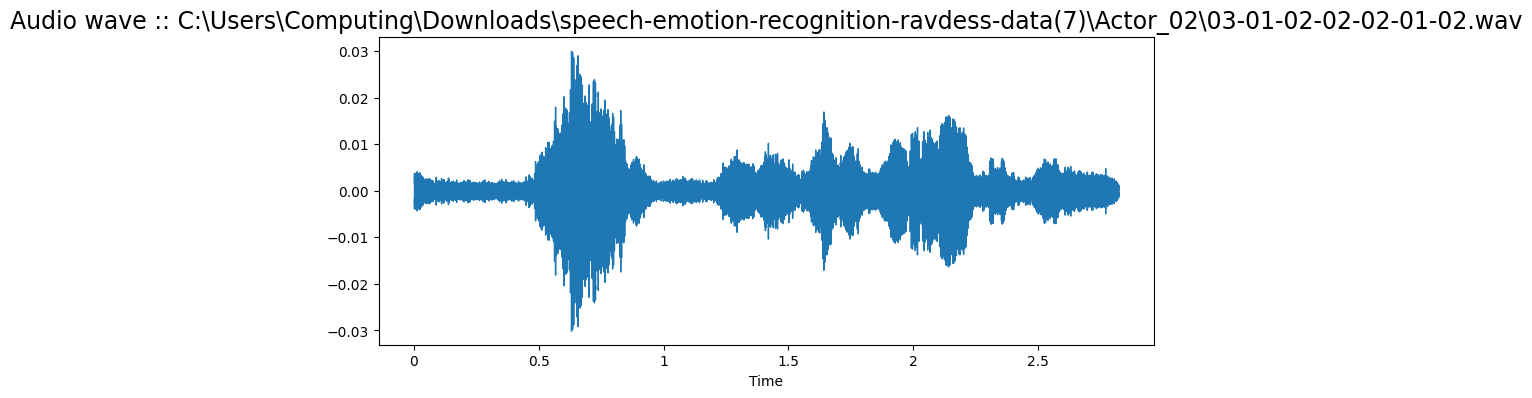

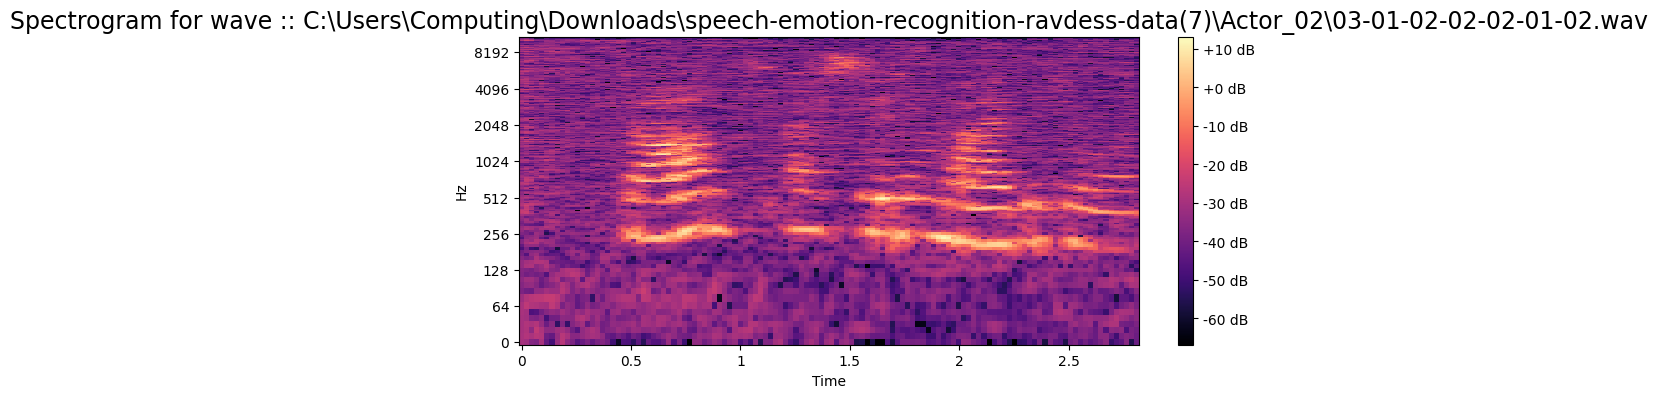

In [6]:

## Get features from the audio file
def get_features(path):
    data, sample_rate = read_audio(path)
    
    funcs = ['standard', add_noise, pitch]  # List of functions
    features = []

    # First processing
    func1_data = processing_audio(data, sample_rate, funcs)
    func2_data = processing_audio(func1_data, sample_rate, funcs)

    # Extract features from the processed audio
    feature = feature_extraction(func2_data, sample_rate)
    print("First feature shape:", feature.shape)  # Print feature shape

    if feature.shape == (20, 104):
        features.append(feature)

    # Second processing
    func1_data = processing_audio(data, sample_rate, funcs)
    func2_data = processing_audio(func1_data, sample_rate, funcs)

    # Extract features from the processed audio
    feature = feature_extraction(func2_data, sample_rate)
    print("Second feature shape:", feature.shape)  # Print feature shape

    if feature.shape == (20, 104):
        features.append(feature)

    # Third processing
    func1_data = processing_audio(data, sample_rate, funcs)
    func2_data = processing_audio(func1_data, sample_rate, funcs)

    # Extract features from the processed audio
    feature = feature_extraction(func2_data, sample_rate)
    print("Third feature shape:", feature.shape)  # Print feature shape

    if feature.shape == (20, 104):
        features.append(feature)

    return features

# Display the waveform and spectrogram
def display(number):
    data, sample_rate = read_audio(paths[number])
    
    # Extract MFCC features
    mfcc_feature = feature_extraction(data, sample_rate)
    print("MFCC feature length:", len(mfcc_feature))
    print("Emotion:", get_emotion(emotions[number]))  # Print the emotion associated with the audio
    
    # Apply various augmentations
    data, sample_rate = add_noise(data, sample_rate)
    data, sample_rate = stretch(data, sample_rate)
    data, sample_rate = pitch(data, sample_rate)
    
    # Draw waveform and spectrogram
    draw_wave(paths[number], data, sample_rate)
    draw_spectrogram(paths[number], data, sample_rate)
    
    return data, sample_rate
# Example usage for displaying and playing an audio sample
d, sr = display(70)

# Play the processed audio
Audio(data=d, rate=sr)

In [7]:

X = []  # List to store features
Y = []  # Another list, assuming you will use it later

for indx in range(len(paths)):
    value = get_features(paths[indx]) 
    if value:  # Check if value is not empty
        for item in value:
            X.append(item)  # Append each item to X
            Y.append(np.eye(8)[emotions[indx] - 1]) 


First feature shape: (20, 104)
Second feature shape: (20, 104)
Third feature shape: (20, 104)
First feature shape: (20, 104)
Second feature shape: (20, 104)
Third feature shape: (20, 104)
First feature shape: (20, 104)
Second feature shape: (20, 104)
Third feature shape: (20, 104)
First feature shape: (20, 104)
Second feature shape: (20, 104)
Third feature shape: (20, 104)
First feature shape: (20, 104)
Second feature shape: (20, 104)
Third feature shape: (20, 104)
First feature shape: (20, 104)
Second feature shape: (20, 104)
Third feature shape: (20, 104)
First feature shape: (20, 104)
Second feature shape: (20, 104)
Third feature shape: (20, 104)
First feature shape: (20, 104)
Second feature shape: (20, 104)
Third feature shape: (20, 104)
First feature shape: (20, 104)
Second feature shape: (20, 104)
Third feature shape: (20, 104)
First feature shape: (20, 104)
Second feature shape: (20, 104)
Third feature shape: (20, 104)
First feature shape: (20, 104)
Second feature shape: (20, 10

In [27]:
#1, n_class = 8
#np.eye(8[index -1]#0-7)
encoder = OneHotEncoder()
encoder.fit_transform(np.array([1,2,3,4,1,5,6,7,8]).reshape(-1,1)).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [9]:
x_train, x_test , y_train , y_test = train_test_split(np.array(X),np.array(Y),test_size=0.2,random_state=11, shuffle=True )
print('train x shape', x_train.shape)
print('test x shape', x_test.shape)
print('test y shape', y_train.shape)
print('train y shape', y_test.shape)

train x shape (3451, 20, 104)
test x shape (863, 20, 104)
test y shape (3451, 8)
train y shape (863, 8)


In [10]:
trainX = np.expand_dims(x_train, axis=3)
trainX = np.expand_dims(trainX, axis=3)
trainX = np.swapaxes(trainX,1,2)
print('trainX', trainX.shape)

testX = np.expand_dims(x_test, axis=3)
testX = np.expand_dims(testX, axis=3)
testX = np.swapaxes(testX,1,2)
print('testX', testX.shape)

inputShape = trainX.shape[1:]
inputShape

trainX (3451, 104, 20, 1, 1)
testX (863, 104, 20, 1, 1)


(104, 20, 1, 1)

In [13]:

def createModel(inputShape):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(32, 3, padding='same', activation='relu'), input_shape=inputShape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))  # Increased dropout rate to 0.3

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization added
    model.add(Dropout(0.3))  # Increased dropout rate to 0.3

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization added
    model.add(Dense(8, activation='softmax'))

    return model


    
    
    

In [15]:
model = createModel(inputShape)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 104, 20, 1, 32)    128       
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 104, 20, 1, 32)    128       
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 104, 640)          0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 64)                180480    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

In [16]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


# Train the model
hist = model.fit(trainX, y_train, batch_size=140, epochs=80, validation_data=(testX, y_test), callbacks=[reduce, stop])

Epoch 1/80


25/25 [==============================] - 7s 183ms/step - loss: 2.1662 - accuracy: 0.1788 - val_loss: 2.1414 - val_accuracy: 0.1958 - lr: 0.0010
Epoch 2/80
25/25 [==============================] - 4s 167ms/step - loss: 2.0619 - accuracy: 0.2211 - val_loss: 2.1454 - val_accuracy: 0.2005 - lr: 0.0010
Epoch 3/80
25/25 [==============================] - 4s 164ms/step - loss: 1.9546 - accuracy: 0.2790 - val_loss: 2.0278 - val_accuracy: 0.2248 - lr: 0.0010
Epoch 4/80
25/25 [==============================] - 4s 165ms/step - loss: 1.8786 - accuracy: 0.3095 - val_loss: 2.0117 - val_accuracy: 0.2491 - lr: 0.0010
Epoch 5/80
25/25 [==============================] - 4s 165ms/step - loss: 1.8370 - accuracy: 0.3298 - val_loss: 1.8565 - val_accuracy: 0.3569 - lr: 0.0010
Epoch 6/80
25/25 [==============================] - 4s 164ms/step - loss: 1.7863 - accuracy: 0.3428 - val_loss: 1.7483 - val_accuracy: 0.3870 - lr: 0.0010
Epoch 7/80
25/25 [==============================] - 4s 164ms/step - 

In [19]:
# Check the history of validation loss
#print(hist.history['val_loss']) 
print('The accuracy :',model.evaluate(testX,y_test)[1]*100,'%')


27/27 [==============================] - 1s 32ms/step - loss: 0.7520 - accuracy: 0.7984
The accuracy : 79.83777523040771 %


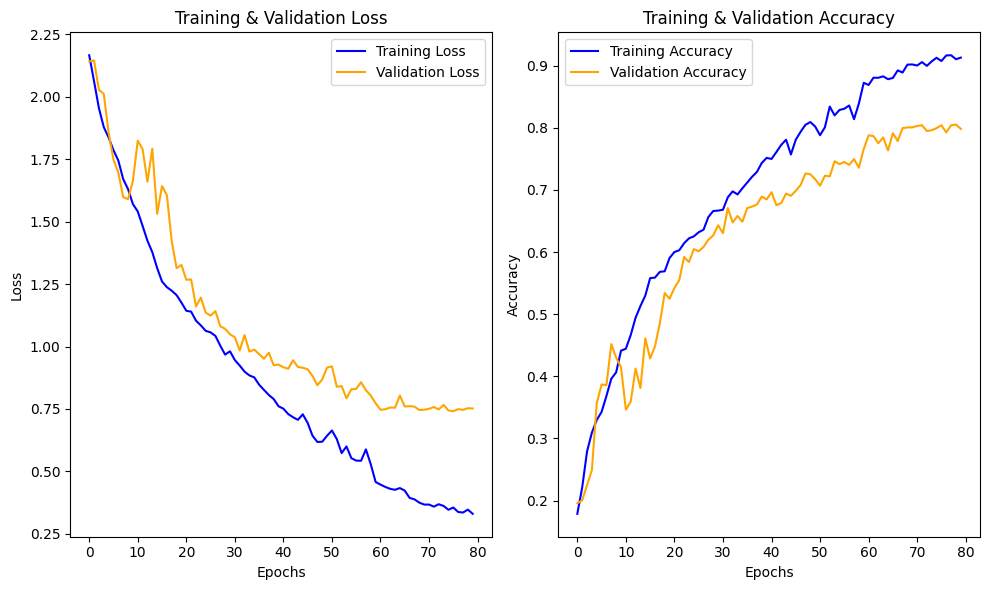

In [58]:
# Extract loss and accuracy data
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']
train_accuracy = hist.history['accuracy']
test_accuracy = hist.history['val_accuracy']

# Define the number of epochs
epochs = range(len(train_loss))  # Automatically adjust to the length of train_loss

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Plot Training and Validation Loss
ax[0].plot(epochs, train_loss, label='Training Loss', color='blue')
ax[0].plot(epochs, test_loss, label='Validation Loss', color='orange')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

# Plot Training and Validation Accuracy
ax[1].plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
ax[1].plot(epochs, test_accuracy, label='Validation Accuracy', color='orange')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

#model.save('C:\\Users\\Computing\\Downloads\\speech-emotion-recognition-ravdess-data(7)\\emotion_model.h5')


plt.tight_layout()
plt.show()

In [23]:
#testing
emotion_model = load_model('C:\\Users\\Computing\\Downloads\\speech-emotion-recognition-ravdess-data(7)\\emotion_model.h5')
y_pred = emotion_model.predict(testX)

27/27 [==============================] - 1s 27ms/step


In [57]:
predY=encoder.inverse_transform(y_pred)
testY=encoder.inverse_transform(y_test)
emotions_predict=[get_emotion(value) for value in predY.flatten()]
emotions_actual=[get_emotion(value) for value in testY.flatten()]
df = pd.DataFrame(columns=['Actual Emotions','Predicted Emotions'])

df['Actual Emotions'] = emotions_actual
df['Predicted Emotions'] = emotions_predict

df.head(20)

,Actual Emotions,Predicted Emotions
0,surprised,surprised
1,calm,calm
2,fearful,fearful
3,neutral,neutral
4,sad,sad
5,neutral,sad
6,happy,sad
7,calm,calm
8,sad,calm
9,sad,sad


Text(120.72222222222221, 0.5, 'actual emotions')

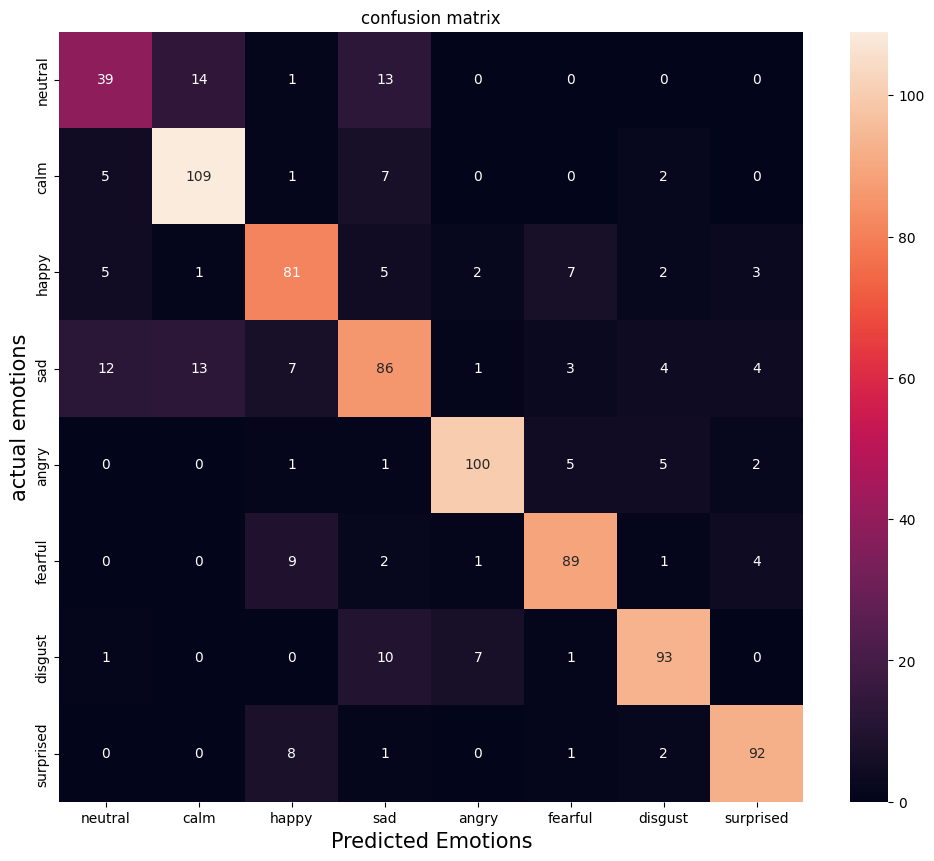

In [56]:
cm= confusion_matrix(testY,predY)
emts=[get_emotion(em) for em in encoder.categories_[0]]
cmt = pd.DataFrame(cm,  index=emts,columns=emts)
plt.figure(figsize=(12,10))

sns.heatmap(cmt,annot=True, fmt='')
plt.title('confusion matrix')
plt.xlabel('Predicted Emotions', size=15)
plt.ylabel('actual emotions', size=15)
